# Kernel methods

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge

...

## (1)

We obtain the solution to a linear regression with respect to our weights w as previously
discussed in the lectures.

$$C(w) = \frac{1}{2}\sum_{n=1}^{N}(w^T x_n-y_n)^2+\frac{\lambda}{2}w^Tw$$

To implement this, consider the underlying model y = 2x. Generate data with some Gaussian
noise (100 datapoints). <br>
Solve the optimisation problem for λ = 0, 0.1, 1 as described in the
lectures.

Minimum: <br>
$$0 = \frac{\partial C}{\partial w}=\sum_{n=1}^{N}(w^T x_n-y_n)x_m+\lambda w = x^T x w+\lambda w - x^T y$$
<br> with the solution <br>
$$w_R = \frac{x^T y}{x^T x+\lambda}$$

In [2]:
# generate data
x = np.linspace(1,100,100)
noise = np.random.normal(scale=1, size = 100)

# model is y = 2x
y = 2*x + noise




# calculate weights via formula above
# probably better with einsum
def calculate_w(lamb, _x, _y):
    
    xTx = _x.transpose().dot(_x)
    _m = xTx + lamb
    xTy = _x.transpose().dot(_y)
    w = xTy/_m
    
    return w

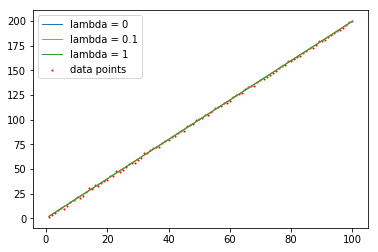

w_formula for lambda = 0, 0.1, 1:
[1.999411813433614, 1.999411222503742, 1.9994059041506107]
w_ridge for lambda = 0, 0.1, 1:
[array([1.99941181]), array([1.99941122]), array([1.9994059])]


In [3]:
lambdas = [0, 0.1, 1] # lambda


ridge = linear_model.Ridge(fit_intercept=False) # Set up ridge regression

w_ridge = [] # weights via ridge regression

w_formula = [] # weights via formula




# calculate weights
for lam in lambdas:
    
    # w_ridge
    ridge.set_params(alpha=lam) # set regularisation parameter
    ridge.fit(x[:, np.newaxis], y) # fit model 
    w_ridge.append(ridge.coef_) # store weights
    
    # w_formula
    w_formula.append(calculate_w(lam, x, y))
    
    label = "lambda = "+str(lam)
    plt.plot(x, calculate_w(lam, x, y)*x, linewidth=1, label = label)
    
    
    
# plot w_formula
plt.scatter(x,y, s=1, c = "red", label = "data points")
plt.legend()
plt.title(" ")
plt.show()


# compare w_formula to w_ridge
print("w_formula for lambda = 0, 0.1, 1:")
print(w_formula)
print("w_ridge for lambda = 0, 0.1, 1:")
print(w_ridge)
    

<br>
There is virtually no difference between the $\lambda $
<br>

## (2)

We now introduce a kernel $φ(x) = (x, x^2)$. Solve again the problem for the underlying model
y = 2x. <br>
Note that this time you need to recalculate the target values $t_n$ appropriately.


Same formula, but with the kernel <br>
$$
C(w) = \frac{1}{2}\sum_{n=1}^{N}(w^T \phi(x_n)-t_n)^2+\frac{\lambda}{2}w^T w
$$
<br> and <br>
$$
w_R = (\phi^T \phi + \lambda \ 1_{2x2})^{-1} \phi^T \ t_n
 $$

In [4]:
# calculate new phi and target values
phi_n = []
t_n_lin = []
t_n_squ = []


for i in range(len(x)):
    phi_n.append([x[i], x[i]**2])
    
    t_n_squ.append([y[i] + y[i]**2]) # for some reason doesn't work  
    t_n_lin.append([y[i]]) # for some reason does work
    
    
# turn into np arrays
phi_n = np.array(phi_n)
t_n_lin = np.array(t_n_lin)
t_n_squ = np.array(t_n_squ)

# choose one
t_n = t_n_lin
#t_n = t_n_squ


# calculate weights from formula with kernel
# probably better with np.einsum
def calc_w_kernel(l, t):

    # matrix in bracket in formula
    _m = phi_n.transpose().dot(phi_n) + np.array([[l, 0], [0, l]])
    _m_inv = np.linalg.inv(_m)
    
    w_kernel = _m_inv.dot( phi_n.transpose().dot(t) )
    
    return w_kernel



# kernel function used for KernelRidge
# probably better with np.einsum
def calc_kernel(x_1, x_2):

    phi_i = np.array([x_1, x_1**2])
    phi_iT = phi_i.transpose()
    phi_j = np.array([x_2, x_2**2])
    k_ij = phi_iT.dot(phi_j)
    
    return k_ij

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


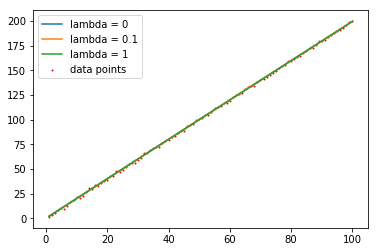

norm(pred_kernelRidge - pred_kernel_formula) for lambda = 0, 0.1, 1:
7.229917944653677e-10
1.8705125794983886e-06
1.716763702870102e-07


In [5]:

w_kernel_formula = [] # weights via formula with kernel
w_kernelRidge = [] # weights via KernelRidge

pred_kernel_formula = [] # predictions
pred_kernelRidge = []


# set up KernelRidge
#kernel_ridge = KernelRidge( kernel='x^2')
kernel_ridge = KernelRidge(kernel = calc_kernel, degree = 2)


# data in right shape
x1 = x[:, np.newaxis]
y1 = y[:, np.newaxis]


j = 0 # counter for w_kernel_formula elements

for lam in lambdas:
    
    # KernelRidge
    kernel_ridge.set_params(alpha=lam)
    kernel_ridge.fit(x1, y1)
    #w_kernelRidge.append(kernel_ridge.coef_) # store weights
    w_kernelRidge.append(kernel_ridge.dual_coef_) # weight vector(s) in kernel space
    
    # prediction from KernelRidge
    pred_kernelRidge.append(kernel_ridge.predict(x1))
    
    
    
    # calculate weights from formula with kernel
    w_kernel_formula.append( calc_w_kernel(lam, t_n) ) 
    
    # prediction from formula
    pred_kernel_formula.append(w_kernel_formula[j].transpose().dot(phi_n.transpose()))
    j += 1
    
    # plot predictions from formula
    plt.plot(x1, pred_kernel_formula[0].transpose(), label = "lambda = "+str(lam) )
    
    
# plot predictions from formula
plt.scatter(x,y, s=1, c = "red", label = "data points")
plt.title(" ")
plt.legend()
plt.show()
    
    
#compare the results 
print("norm(pred_kernelRidge - pred_kernel_formula) for lambda = 0, 0.1, 1:")
for j in range(3):
    print( np.linalg.norm( pred_kernel_formula[j] - pred_kernelRidge[j].transpose() ) )

<br>
For t_n_lin: <br>
KernelRidge and Kernel formula give the same result.

Again there is virtually no difference between the $\lambda $.
<br>

## (3)

Calculate the kernel function $ k(x_n, x_m) = φ(x_n)^T φ(x_m)$

In [6]:
# 100 x 100 matrix?

kernel = phi_n.dot( np.transpose(phi_n) )
print(kernel)

[[2.0000000e+00 6.0000000e+00 1.2000000e+01 ... 9.7020000e+03
  9.9000000e+03 1.0100000e+04]
 [6.0000000e+00 2.0000000e+01 4.2000000e+01 ... 3.8612000e+04
  3.9402000e+04 4.0200000e+04]
 [1.2000000e+01 4.2000000e+01 9.0000000e+01 ... 8.6730000e+04
  8.8506000e+04 9.0300000e+04]
 ...
 [9.7020000e+03 3.8612000e+04 8.6730000e+04 ... 9.2246420e+07
  9.4138506e+07 9.6049800e+07]
 [9.9000000e+03 3.9402000e+04 8.8506000e+04 ... 9.4138506e+07
  9.6069402e+07 9.8019900e+07]
 [1.0100000e+04 4.0200000e+04 9.0300000e+04 ... 9.6049800e+07
  9.8019900e+07 1.0001000e+08]]


## (4)

Using this kernel function solve the optimisation problem for the dual variables a.

With $w = \phi^T a $ one gets <br>
$$C(a)=\frac{1}{2}a^T K K a - a^T K t + \frac{1}{2} t^T t+\frac{\lambda}{2} a^T K a$$
<br>
which is minimized for <br>
$$a= ( K+\lambda \ 1_{100x100})^{-1} \ t $$

In [7]:
# a = (k + Lambda)^-1 * t_n

a = []

# calculate a
for lam in lambdas:
    
    # matrix in bracket in formula for a
    m = kernel + np.identity(len(x))*lam
    m_inv = np.linalg.inv(m)
    
    
    a_lam = m_inv.dot(t_n) 
    
    
    a.append(a_lam)
    
    print("\nfor lambda = "+str(lam)+":")
    print(a_lam)


for lambda = 0:
[[-3.82253300e+14]
 [ 1.03504844e+14]
 [-8.26699304e+13]
 [ 8.68105293e+13]
 [ 9.58872719e+12]
 [-1.04102558e+13]
 [-1.62946818e+13]
 [ 4.19426910e+12]
 [ 1.60295371e+13]
 [ 5.32113116e+12]
 [-1.60288119e+11]
 [-4.37505918e+12]
 [ 3.27574805e+12]
 [-2.71647821e+11]
 [ 7.18540675e+11]
 [-1.76334688e+12]
 [ 6.64084560e+10]
 [ 7.85542721e+11]
 [ 1.73855022e+12]
 [ 1.53860187e+12]
 [ 1.15353059e+12]
 [ 6.35668014e+11]
 [-1.43507365e+12]
 [-5.22798384e+11]
 [-4.25136708e+11]
 [ 5.19475581e+11]
 [-2.40799666e+11]
 [-7.78357234e+10]
 [-7.45870941e+10]
 [-3.93697964e+11]
 [ 3.05741886e+09]
 [-2.43164989e+11]
 [-8.39873327e+10]
 [ 4.48117802e+10]
 [-2.54692368e+11]
 [-1.89569766e+11]
 [-1.46975382e+10]
 [ 1.42480606e+11]
 [ 1.89549814e+10]
 [-1.01180430e+11]
 [-5.79692935e+10]
 [ 5.83612585e+10]
 [-1.74460863e+11]
 [ 1.63952316e+11]
 [-3.14348891e+11]
 [-1.64554393e+10]
 [ 5.84681616e+10]
 [ 1.23409775e+11]
 [ 3.81434438e+10]
 [ 6.52783272e+10]
 [-1.07995246e+11]
 [-3.97030449e

## (5)

Show that both solutions agree by obtaining w from your solution a.

In [8]:
w_dual = []

# weights from a

for a_lam in a:
    w_froma = phi_n.transpose().dot(a_lam)
    w_dual.append(w_froma)
    
print("compare results:\n")
print("from Kernel via formula:")
print(w_kernel_formula)
print("\nfrom a:")
print(w_dual)

compare results:

from Kernel via formula:
[array([[ 2.00561865e+00],
       [-8.23480935e-05]]), array([[ 2.00560916e+00],
       [-8.22301124e-05]]), array([[ 2.00552380e+00],
       [-8.11683329e-05]])]

from a:
[array([[-1.20776367],
       [10.6875    ]]), array([[ 2.00560918e+00],
       [-8.22231232e-05]]), array([[ 2.00552380e+00],
       [-8.11665086e-05]])]


For t_n_linear and t_n_squared: <br> 
$\ $ Results for $ \lambda = 0 $ disagree. <br>
$\ $ Results for $ \lambda = 0.1, 1 $ agree. 
 